In [1]:
from test_utils import *
from blobmodel import BlobShapeEnum, BlobShapeImpl
import numpy as np
import cosmoplots as cp
from imaging_methods import *

plt.style.use(["cosmoplots.default"])
plt.rcParams["text.latex.preamble"] = (
    r"\usepackage{amsmath} \usepackage{mathptmx} \usepackage{amssymb} "
)


MAKE_PLOTS = True
T = 10000
Lx = 8
Ly = 8
nx = 8
ny = 8
dt = 0.1
bs = BlobShapeImpl(BlobShapeEnum.gaussian, BlobShapeEnum.gaussian)
K = 10000

# Method parameters
method_parameters = {
    "preprocessing": {"radius": 1000},
    "2dca": {
        "refx": 6,
        "refy": 5,
        "threshold": 2,
        "window": 60,
        "check_max": 1,
        "single_counting": True,
    },
    "gauss_fit": {"size_penalty": 5, "aspect_penalty": 0.2, "tilt_penalty": 0.2},
    "contouring": {
        "threshold_factor": 0.3,
        "threshold_factor_cc": 0.5,
        "com_smoothing": 10,
    },
    "taud_estimation": {"cutoff": 1e6, "nperseg": 1e3},
}

figures_dir = "integrated_tests_figures"

In [52]:
def movie(
    dataset: xr.Dataset,
    interval: int = 100,
    interpolation: str = "spline16",
    file_name=None,
) -> None:
    dt = get_dt(dataset)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    t_dim = "time"
    refx, refy = int(dataset["refx"].item()), int(dataset["refy"].item())

    contour_cc = get_contour_evolution(
        dataset.cross_corr,
        method_parameters["contouring"]["threshold_factor_cc"],
    )
    contour_ca = get_contour_evolution(
        dataset.cond_av,
        method_parameters["contouring"]["threshold_factor"],
    )
    max_ca = im.compute_maximum_trajectory_da(dataset, variable = "cond_av", method=method)
    max_cc = im.compute_maximum_trajectory_da(dataset, variable = "cross_corr", method=method)

    def get_title(i):
        time = dataset[t_dim][i]
        if dt < 1e-3:
            title = r"t$={:.2f}\,\mu$s".format(time * 1e6)
        else:
            title = r"t$={:.2f}\,$s".format(time)
        return title

    def animate_2d(i: int):
        arr0 = dataset.cond_av.isel(**{t_dim: i})
        arr1 = dataset.cross_corr.isel(**{t_dim: i})
        im0.set_data(arr0)
        im0.set_clim(0, np.max(dataset.cond_av.values))
        im1.set_data(arr1)
        im1.set_clim(0, np.max(dataset.cross_corr.values))

        c0 = contour_ca.contours.isel(time=i).data
        c1 = contour_cc.contours.isel(time=i).data
        line0[0].set_data(c0[:, 0], c0[:, 1])
        line1[0].set_data(c1[:, 0], c1[:, 1])
        com_scatter0.set_offsets(contour_ca.center_of_mass.values[i, :])
        com_scatter1.set_offsets(contour_cc.center_of_mass.values[i, :])
        max_scatter0.set_offsets(max_ca.values[i, :])
        max_scatter1.set_offsets(max_cc.values[i, :])

        tx.set_text(get_title(i))

    # tx = ax[0].set_title(get_title(0))
    tx = fig.suptitle(get_title(0))
    ax[0].set_title("Cond. Av.")
    ax[1].set_title("Cross Corr.")
    ax[0].scatter(
        dataset.R.isel(x=refx, y=refy).item(),
        dataset.Z.isel(x=refx, y=refy).item(),
        color="black",
    )
    ax[1].scatter(
        dataset.R.isel(x=refx, y=refy).item(),
        dataset.Z.isel(x=refx, y=refy).item(),
        color="black",
    )
    div0 = make_axes_locatable(ax[0])
    div1 = make_axes_locatable(ax[1])
    cax0 = div0.append_axes("right", "5%", "5%")
    cax1 = div1.append_axes("right", "5%", "5%")
    im0 = ax[0].imshow(
        dataset.cond_av.isel(**{t_dim: 0}),
        origin="lower",
        interpolation=interpolation,
    )
    im1 = ax[1].imshow(
        dataset.cross_corr.isel(**{t_dim: 0}),
        origin="lower",
        interpolation=interpolation,
    )
    com_scatter0 = ax[0].scatter(
        contour_ca.center_of_mass.values[0, 0],
        contour_ca.center_of_mass.values[0, 1],
        marker="s",
        color="green",
    )
    com_scatter1 = ax[1].scatter(
        contour_cc.center_of_mass.values[0, 0],
        contour_cc.center_of_mass.values[0, 1],
        marker="s",
        color="green",
    )
    max_scatter0 = ax[0].scatter(
        max_ca.values[0, 0], max_ca.values[0, 1], marker="^", color="orange"
    )
    max_scatter1 = ax[1].scatter(
        max_cc.values[0, 0], max_cc.values[0, 1], marker="^", color="orange"
    )
    line0 = ax[0].plot([], [], ls="--", color="black")
    line1 = ax[1].plot([], [], ls="--", color="black")
    fig.colorbar(im0, cax=cax0)
    fig.colorbar(im1, cax=cax1)

    im0.set_extent(
        (dataset.R[0, 0], dataset.R[0, -1], dataset.Z[0, 0], dataset.Z[-1, 0])
    )
    im1.set_extent(
        (dataset.R[0, 0], dataset.R[0, -1], dataset.Z[0, 0], dataset.Z[-1, 0])
    )

    ani = animation.FuncAnimation(
        fig, animate_2d, frames=dataset[t_dim].values.size, interval=interval
    )

    if file_name is not None:
        ani.save(file_name, writer="ffmpeg", fps=10)
        os.system(
            "gifsicle -i {} -O3 --colors 32 --lossy=150 -o {}".format(
                file_name, file_name
            )
        )

    plt.show()

def get_tde_velocities(refx, refy, gpi_ds):
    import velocity_estimation as ve

    eo = ve.EstimationOptions()
    eo.method = ve.TDEMethod.CC

    ccf_min_lag = 1
    ca_min = 2.5
    ca_max = np.inf
    eo.cache = False

    eo.use_3point_method = True
    eo.neighbour_options = ve.NeighbourOptions(
        ccf_min_lag=ccf_min_lag, max_separation=1, min_separation=1
    )

    eo.ca_options.length_of_return = 1e-4
    eo.ca_options.distance = 0
    eo.ca_options.min_threshold = ca_min
    eo.ca_options.max_threshold = ca_max
    eo.ca_options.interpolate = True

    try:
        pd = ve.estimate_velocities_for_pixel(
            refx, refy, ve.CModImagingDataInterface(gpi_ds, get_dead_pixel_mask()), eo
        )
        vx, vy = pd.vx / 100, pd.vy / 100
    except ValueError:
        vx, vy = np.nan, np.nan
    return vx, vy

In [3]:
def get_synthetic_data():
    alpha = np.pi / 8
    vx_input = np.cos(alpha)
    vy_intput = np.sin(alpha)
    lx_input = 1
    ly_input = 1
    theta_input = 0

    ds = make_2d_realization(
        Lx,
        Ly,
        T,
        nx,
        ny,
        dt,
        K,
        vx=vx_input,
        vy=vy_intput,
        lx=lx_input,
        ly=ly_input,
        theta=theta_input,
        bs=bs,
    )
    ds = im.run_norm_ds(ds, method_parameters["preprocessing"]["radius"])
    return ds


def make_decoherence_realization(rand_coeff):
    def blob_getter():
        return get_blob(
            amplitude=np.random.exponential(),
            vx=np.random.uniform(1 - rand_coeff, 1 + rand_coeff),
            vy=np.random.uniform(-rand_coeff, rand_coeff),
            posx=np.random.uniform(0, Lx),
            posy=np.random.uniform(0, Ly),
            lx=1,
            ly=1,
            t_init=np.random.uniform(0, T),
            bs=bs,
            theta=0,  # 0 but go to the != 0 branch in the blob.py function
        )

    ds = make_2d_realization(
        Lx,
        Ly,
        T,
        nx,
        ny,
        dt,
        K,
        vx=0,  # velocities are overriden
        vy=0,
        lx=1,
        ly=1,
        theta=0,
        bs=bs,
        blob_getter=blob_getter,
    )
    ds = im.run_norm_ds(ds, method_parameters["preprocessing"]["radius"])
    return ds


def get_velocities_from_position(average_ds, contour, position, delta, extra_mask=None):
    velocity_ds = im.get_contour_velocity(
        position,
        method_parameters["contouring"]["com_smoothing"],
    )
    v, w = im.get_average_velocity_for_near_com(
        average_ds, contour, velocity_ds, distance=delta, extra_mask=extra_mask
    )
    return v, w

def get_combined_mask(
    average_ds: xr.Dataset,
    position_da: xr.DataArray,
    extra_condition: xr.DataArray,
    distance: float,
):
    near_positions = is_position_near_reference(average_ds, position_da, distance)
    mask = near_positions & extra_condition

    # Restrict to the single longest contiguous block of True values
    return im.restrict_to_largest_true_subarray(mask)

In [75]:
shot = 1160616026
manager = im.GPIDataAccessor(
    "/home/sosno/Git/experimental_database/plasma_discharges.json"
)
ds = manager.read_shot_data(shot, preprocessed=True, data_folder="../data")
#ds = make_decoherence_realization(1)

tdca_params = method_parameters["2dca"]
tdca_params["refx"] = 6
tdca_params["refy"] = 6
events, average_ds = im.find_events_and_2dca(
        ds,
        tdca_params["refx"],
        tdca_params["refy"],
        threshold=tdca_params["threshold"],
        check_max=tdca_params["check_max"],
        window_size=tdca_params["window"],
        single_counting=tdca_params["single_counting"],
    )

Found 3330 events
Discarded 2561 events. Not max 2109, zero len 0, truncation 0, single count 452


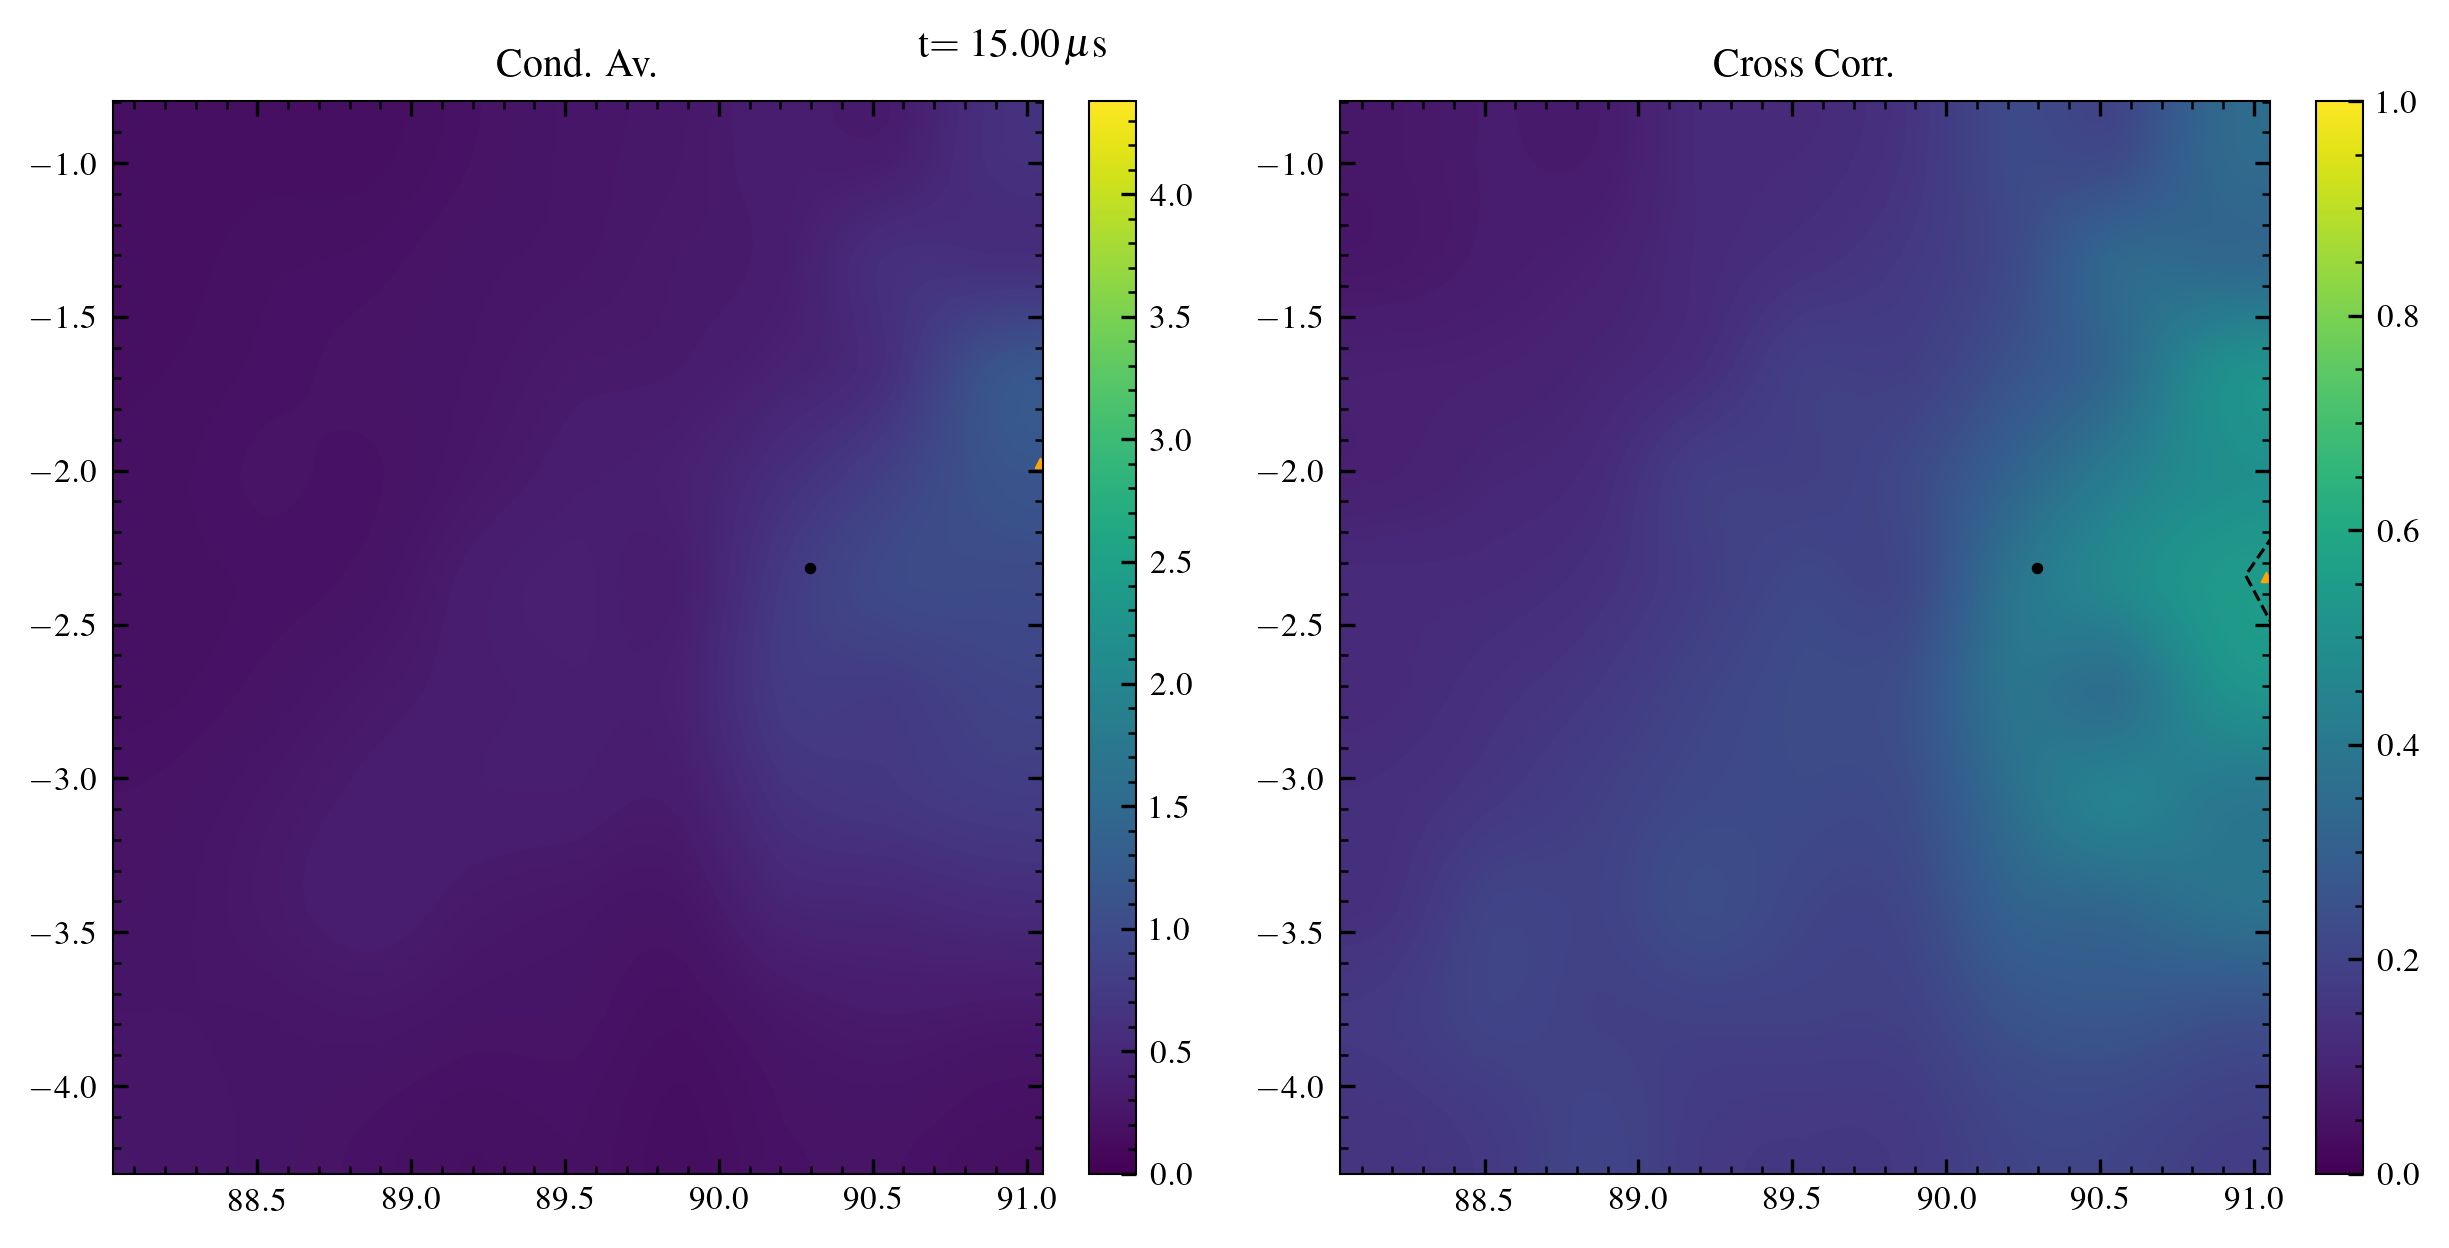

In [53]:
movie(average_ds, file_name="trajectories.gif")

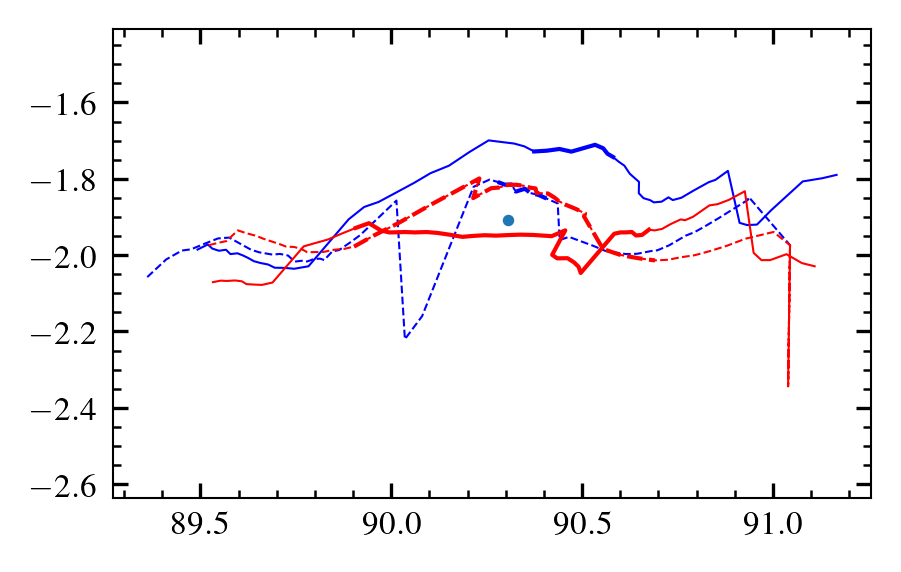

Ca centroid: 565.9599, -67.33
Ca max: 382.3862, -132.30
Cc centroid: 497.2228, 1.54
Cc max: 629.8448, -24.90


/home/sosno/Git/imaging-methods/.venv/lib/python3.10/site-packages/velocity_estimation/two_dim_velocity_estimates.py:350: UserWarning: Pixel (6, 7) does not fulfill cross-correlation time lag condition with respect to pixel of (6, 6). Updating.
  warnings.warn(


TDE: 684.6148, -342.33


In [76]:
method = "fit"
cond_av_max = im.compute_maximum_trajectory_da(average_ds, "cond_av", method=method)
cross_corr_max = im.compute_maximum_trajectory_da(average_ds, "cross_corr", method=method)
refx, refy = tdca_params["refx"], tdca_params["refy"]
delta = average_ds.R.isel(x=refx, y=refy).item() - average_ds.R.isel(x=refx - 1, y=refy).item()
contour_ca = im.get_contour_evolution(
    average_ds.cond_av,
    method_parameters["contouring"]["threshold_factor"],
    max_displacement_threshold=None,
    com_method="centroid",
)
ca_centroid = contour_ca.center_of_mass
contour_cc = im.get_contour_evolution(
    average_ds.cross_corr,
    method_parameters["contouring"]["threshold_factor_cc"],
    max_displacement_threshold=None,
    com_method="centroid",
)
ca_max = average_ds.cond_av.max(dim=["x", "y"]).values
cc_max = average_ds.cross_corr.max(dim=["x", "y"]).values

cc_centroid = contour_cc.center_of_mass
    
fig, ax = plt.subplots()

R, Z = (
    ds.R.isel(x=tdca_params["refx"], y=tdca_params["refy"]).item(),
    ds.Z.isel(x=tdca_params["refx"], y=tdca_params["refy"]).item(),
)


ax.scatter(R, Z)

is_ca_high_enough = ca_max > 0.75 * np.max(ca_max)
is_cc_high_enough = cc_max > 0.75 * np.max(cc_max)

mask_ca_centroid = get_combined_mask(average_ds, ca_centroid, is_ca_high_enough, delta)
mask_ca_max = get_combined_mask(average_ds, cond_av_max, is_ca_high_enough, delta)
mask_cc_centroid = get_combined_mask(average_ds, cc_centroid, is_cc_high_enough, delta)
mask_cc_max = get_combined_mask(average_ds, cross_corr_max, is_cc_high_enough, delta)

ax.plot(ca_centroid.values[:, 0], ca_centroid.values[:, 1], color="blue", lw=0.5)
ax.plot(ca_centroid.values[:, 0][mask_ca_centroid], ca_centroid.values[:, 1][mask_ca_centroid], color="blue", lw=1)

ax.plot(cond_av_max.values[:, 0], cond_av_max.values[:, 1], color="blue", ls="--", lw=0.5)
ax.plot(cond_av_max.values[:, 0][mask_ca_max], cond_av_max.values[:, 1][mask_ca_max], color="blue", ls = "--", lw=1)

ax.plot(
    cc_centroid.values[:, 0], cc_centroid.values[:, 1], color="red", lw=0.5
)

ax.plot(cc_centroid.values[:, 0][mask_cc_centroid], cc_centroid.values[:, 1][mask_cc_centroid], color="red", lw=1)

ax.plot(
    cross_corr_max.values[:, 0], cross_corr_max.values[:, 1], color="red", ls="--", lw=0.5
)
ax.plot(cross_corr_max.values[:, 0][mask_cc_max], cross_corr_max.values[:, 1][mask_cc_max], color="red", ls = "--", lw=1)

ax.set_aspect('equal', adjustable='datalim')
plt.savefig("trajectories.pdf", bbox_inches="tight")
plt.show()

v_ca_centroid, w_ca_centroid = get_averaged_velocity_from_position(ca_centroid, mask_ca_centroid, window_size=1)
v_ca_max, w_ca_max = get_averaged_velocity_from_position(cond_av_max, mask_ca_max, window_size=1)
v_cc_centroid, w_cc_centroid = get_averaged_velocity_from_position(cc_centroid, mask_cc_centroid, window_size=1)
v_cc_max, w_cc_max = get_averaged_velocity_from_position(cross_corr_max, mask_cc_max, window_size=1)

print(
    "Ca centroid: {:.4f}, {:.2f}".format(v_ca_centroid / 100, w_ca_centroid / 100)
)
print("Ca max: {:.4f}, {:.2f}".format(v_ca_max / 100, w_ca_max / 100))
print(
    "Cc centroid: {:.4f}, {:.2f}".format(v_cc_centroid / 100, w_cc_centroid / 100)
)
print("Cc max: {:.4f}, {:.2f}".format(v_cc_max / 100, w_cc_max / 100))

v_tde, w_tde = get_tde_velocities(refx, refy, ds)

print("TDE: {:.4f}, {:.2f}".format(v_tde, w_tde))

0.3939971923828125
<xarray.DataArray (time: 61)> Size: 488B
array([89.31042429, 89.35417159, 89.39598925, 89.42811335, 89.45815065,
       89.48618225, 89.52229397, 89.56035748, 89.59280488, 89.62665494,
       89.67714046, 89.70353162, 89.72888828, 89.7536095 , 89.77137983,
       89.78666984, 89.79990802, 89.81506913, 89.83161963, 89.85364462,
       89.88002381, 89.92318428, 89.98810185, 90.2018374 , 90.16287747,
       90.21764936, 90.24839735, 90.26641786, 90.28912016, 90.30264438,
       90.31598871, 90.33684843, 90.35542823, 90.37350008, 90.39971228,
       90.424757  , 90.37209093, 90.45609713, 90.52244394, 90.55113143,
       90.58889976, 90.61825631, 90.65031546, 90.67706389, 90.70484805,
       90.73420647, 90.7639153 , 90.81160783, 90.82502486, 90.92797415,
       90.95029982, 91.01030957, 91.04499817, 91.04499817, 91.04499817,
       91.04499817, 91.04499817, 91.04499817, 91.04499817, 91.04499817,
       91.04499817])
Coordinates:
  * time     (time) float64 488B -1.5e-05 

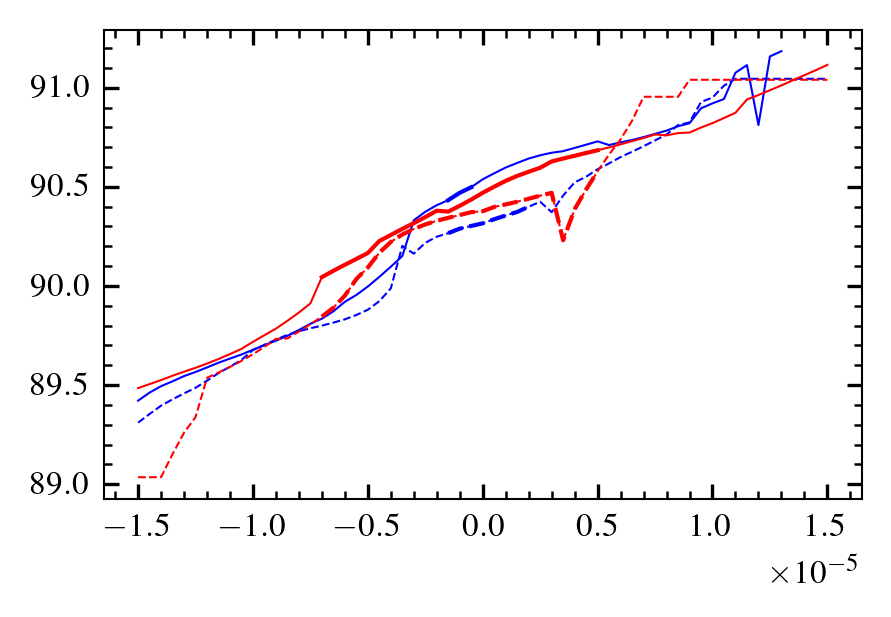

In [74]:
fig, ax = plt.subplots()
index = 0
print(delta)

ax.plot(average_ds.time.values, ca_centroid[:, index], color="blue", lw=0.5)
ax.plot(average_ds.time.values[mask_ca_centroid], ca_centroid[:, index][mask_ca_centroid], color="blue", lw=1)
ax.plot(average_ds.time.values, cond_av_max[:, index], color="blue", lw=0.5, ls="--")
ax.plot(average_ds.time.values[mask_ca_max], cond_av_max[:, index][mask_ca_max], color="blue", lw=1, ls="--")

ax.plot(average_ds.time.values, cc_centroid[:, index], color="red", lw=0.5)
ax.plot(average_ds.time.values[mask_cc_centroid], cc_centroid[:, index][mask_cc_centroid], color="red", lw=1)
ax.plot(average_ds.time.values, cross_corr_max[:, index], color="red", lw=0.5, ls="--")
ax.plot(average_ds.time.values[mask_cc_centroid], cross_corr_max[:, index][mask_cc_centroid], color="red", lw=1, ls="--")
print(cond_av_max[:, index])

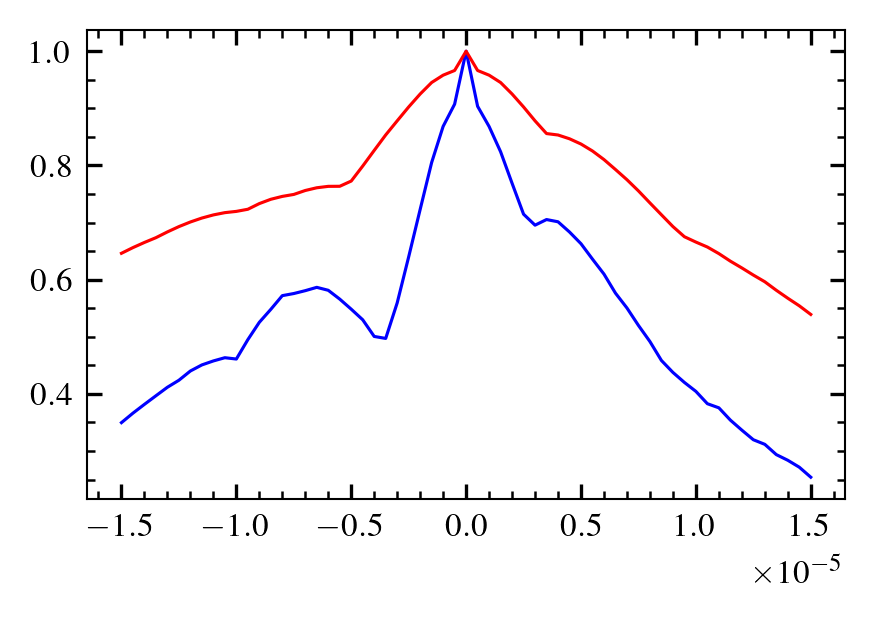

In [12]:
fig, ax = plt.subplots()

ax.plot(average_ds.time.values, ca_max/np.max(ca_max), color="blue")
ax.plot(average_ds.time.values, cc_max, color="red")

In [54]:
# average_ds.cross_corr.isel(x=refx, y=refy).values

import scipy.signal as ssi

half_window = 30
start_idx = ds.sizes["time"] - half_window
end_idx = ds.sizes["time"] + half_window + 1

ref_ts = ds.frames.isel(x=refx, y=refy).values
pixel = ds.frames.isel(x=refx, y=refy).values

ref_ts = (ref_ts - ref_ts.mean()) / ref_ts.std()
pixel = (pixel - pixel.mean()) / pixel.std()

cov_sums_full = ssi.correlate(pixel, ref_ts, mode="full")

cov_sums_full[start_idx:end_idx]/len(ref_ts)
np.max(cov_sums_full/ref_ts.size)

0.9999999999999997

In [65]:
mask_ca_centroid

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [66]:
get_averaged_velocity_from_position(ca_centroid, mask_ca_centroid, window_size=1)

(92283.43972564077, 51648.060445252)

In [67]:
velocity =  get_velocity_from_position(ca_centroid, 3)

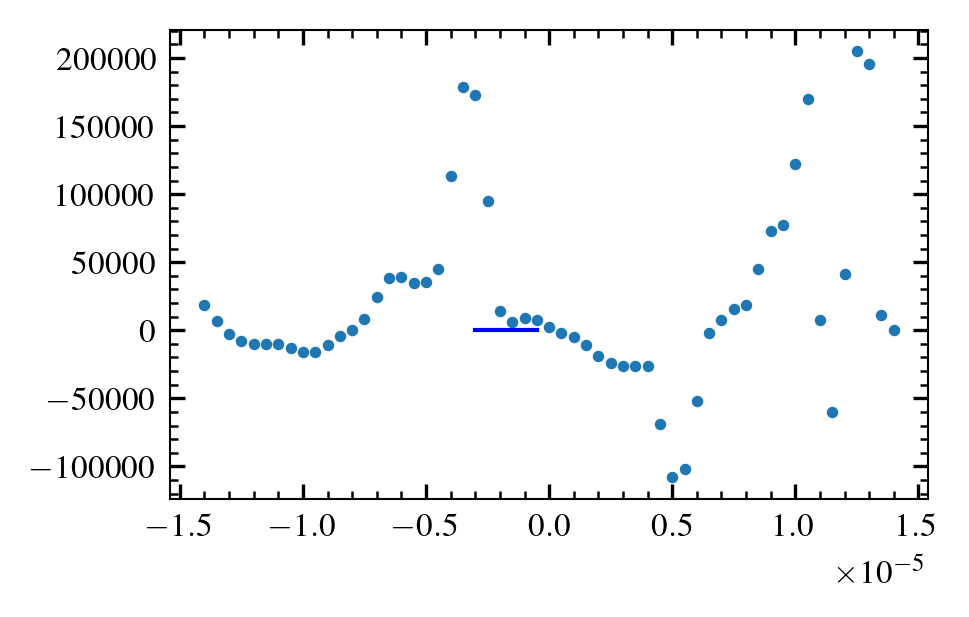

In [71]:
fig, ax = plt.subplots()

ax.scatter(velocity.time, velocity.values[:, 1])
ax.plot(average_ds.time.values[mask_ca_centroid], ca_centroid[:, index][mask_ca_centroid], color="blue", lw=1)